In [1]:
import torch
from torch.backends import cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import *
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from config.config_cloud import Config_cloud
from data.dataset import CloudDataset

import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

In [2]:
Cfg = Config_cloud()

In [3]:
data = pd.read_pickle('data/data_train.pkl')
data_met = pd.read_pickle('data/data_train_met.pkl')
dataset = CloudDataset(data,data_met)
#train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=Cfg.num_workers)

In [3]:
data_met = pd.read_pickle('data/data_test_met.pkl')

In [5]:
list(data_met['sky'].keys())

['2018010218',
 '2018010221',
 '2018010300',
 '2018010303',
 '2018010306',
 '2018010309',
 '2018010312',
 '2018010315',
 '2018010318',
 '2018010321',
 '2018010400',
 '2018010403',
 '2018010406',
 '2018010409',
 '2018010412',
 '2018010415',
 '2018010418',
 '2018010421',
 '2018010500',
 '2018010503',
 '2018010506',
 '2018010509',
 '2018010512',
 '2018010515',
 '2018010518',
 '2018010521',
 '2018010600',
 '2018010603',
 '2018010606',
 '2018010609',
 '2018010612',
 '2018010615',
 '2018010918',
 '2018010921',
 '2018011000',
 '2018011003',
 '2018011006',
 '2018011009',
 '2018011012',
 '2018011015',
 '2018011018',
 '2018011021',
 '2018011100',
 '2018011103',
 '2018011106',
 '2018011109',
 '2018011112',
 '2018011115',
 '2018011118',
 '2018011121',
 '2018011200',
 '2018011203',
 '2018011206',
 '2018011209',
 '2018011212',
 '2018011215',
 '2018011218',
 '2018011221',
 '2018011300',
 '2018011303',
 '2018011306',
 '2018011309',
 '2018011312',
 '2018011315',
 '2018011618',
 '2018011621',
 '20180117

In [6]:
data_met['sky']['2018050321'].shape

(20, 160, 128)

In [8]:
data_met['ground'].keys()

dict_keys([])

In [15]:
import numpy as np
import torch
import torch.utils.data
from torch.utils.data import DataLoader
import torch.nn.functional as F

import pandas as pd
import random


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


class CloudDataset(torch.utils.data.Dataset):
    def __init__(self, data, data_met, window=24, horizon=24, dtype=torch.float):
        super().__init__()
        self._data = data['cloud']
        self.HGTs = data_met['HGTs']
        self.PRMSL = data_met['PRMSL']
        self.TMP = data_met['TMP'] 
        self.winds = data_met['winds']
 
        self.cloud_list = np.stack(list(self._data.keys())).astype(int)
        self.cloud_all = np.stack(list(self._data.values()))
        self.met_list = np.stack(list(self.HGTs.keys())).astype(int)
        
        self._window = window
        self._horizon = horizon
        self._dtype = dtype
      

    def __getitem__(self, index):
        index = np.minimum(len(self._data)-self._window-self._horizon-1, index)

        #met_ind = np.where(self.met_list<=self.cloud_list[index+self._window+1])[0][-1]
        met_ind = find_nearest(self.met_list, self.cloud_list[index+self._window])
        
        cloud_x = self.cloud_all[index:index+self._window]
        cloud_x= cloud_x/255
        
        HGTs_x = self.HGTs[str(met_ind)]
        PRMSL_x = self.PRMSL[str(met_ind)]
        TMP_x = self.TMP[str(met_ind)]
        winds_x = self.winds[str(met_ind)]
        
        cloud_y = self.cloud_all[index+self._window+5:index+self._window+self._horizon:6]
        cloud_y = cloud_y/255
        
        x = np.concatenate([cloud_x,HGTs_x,PRMSL_x,TMP_x,winds_x],axis=0)
            
        x = torch.from_numpy(x).type(self._dtype)
        cloud_y = torch.from_numpy(cloud_y).type(self._dtype)
        
        return x, cloud_y
    
    
    def __len__(self):
        return len(self._data)-self._window-self._horizon-1
    
    
def generate_valid_set(Cfg):
    valid_fold_list = np.random.choice(50, Cfg.batch_size)#random.sample(range(0, 50), Cfg.batch_size)
    data = pd.read_pickle('data/data_test.pkl')
    data_met = pd.read_pickle('data/data_test_met.pkl')
    data = data['cloud']
    HGTs = data_met['HGTs']
    PRMSL = data_met['PRMSL']
    TMP = data_met['TMP'] 
    winds = data_met['winds']
    cloud_clip = np.load("data/valid_cloud_clip.npy",allow_pickle=True)
    met_clip = np.load('data/test_meta_clip.npy',allow_pickle=True)

    X = []
    Y = []
    for valid_id in valid_fold_list:
        clip = np.sort(cloud_clip[valid_id])
        start = random.sample(range(0, 47), 1)[0]
        end = start+24
        train_ind = clip[start:end]
        test_ind = clip[end+5:end+24:6]
        
        met_ind = find_nearest(met_clip[valid_id], clip[end])

        x = []
        y = []
        for i in train_ind:
            x.append(data[str(i)])
        for j in test_ind:
            y.append(data[str(j)])
        x = np.stack(x)/255
        y = np.stack(y)/255
        
        x = np.concatenate([x, HGTs[str(met_ind)], PRMSL[str(met_ind)], TMP[str(met_ind)],winds[str(met_ind)] ],axis=0)

        X.append(x)
        Y.append(y)

    X = np.stack(X)
    Y = np.stack(Y)

    X = torch.from_numpy(X).type(torch.float)
    Y = torch.from_numpy(Y).type(torch.float)
    
    return X, Y

In [13]:
dataset = CloudDataset(data,data_met)
x, cloud_y = dataset[34]

In [14]:
x.size()

torch.Size([42, 160, 128])

In [16]:
X,Y = generate_valid_set(Cfg)

In [17]:
X.size()

torch.Size([32, 42, 160, 128])

In [34]:
import segmentation_models_pytorch as smp
in_channels = 24
cloud2cloud = smp.PSPNet(encoder_name='resnet34', classes=4, encoder_weights='imagenet')
cloud2cloud.encoder.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)

In [18]:
met_encode = smp.PSPNet(encoder_name='resnet18', encoder_weights='imagenet')

In [33]:
met_z = met_encode.encoder(x[:,:3,:,:])
cloud_z = cloud2cloud.encoder(x[:,:24,:,:])

In [34]:
cloud_z[0] = met_z[0]+cloud_z[0]
output = cloud2cloud.decoder(z)


In [25]:
met_z[0].shape

torch.Size([1, 512, 5, 4])

In [15]:
class Cloud2Cloud(nn.Module):
    def __init__(self, in_channels=24):
        super(Cloud2Cloud, self).__init__()

        self.cloudNet = smp.PSPNet(encoder_name='resnet34', classes=4, encoder_weights='imagenet')
        self.cloudNet.encoder.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(5,5), stride=(2,2), padding=(2,2), bias=False)
        self.metNet= smp.PSPNet(encoder_name='resnet18', encoder_weights='imagenet')
        self.cloud_encoder = self.cloudNet.encoder
        self.met_encoder = self.metNet.encoder  
        self.cloud_decoder = self.cloudNet.decoder

    def forward(self, inputs):

        cloud_z = self.cloud_encoder(inputs[:,:24,:,:])
        met_z = self.met_encoder(inputs[:,24:,:,:])
        cloud_z[0] = met_z[0]+cloud_z[0]        
        output = self.cloud_decoder(cloud_z)
        
        return output

torch.Size([1, 512, 5, 4])

In [66]:
y = cloud2cloud.encoder(cloud_x)
y.size()

AttributeError: 'list' object has no attribute 'size'

In [69]:
y[0].shape

torch.Size([1, 512, 6, 4])

In [73]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

encode_met = get_preprocessing_fn('resnet18', pretrained='imagenet')

In [74]:
y = encode_met(cloud_x)
y.size()

TypeError: sub(): argument 'other' (position 1) must be Tensor, not numpy.ndarray

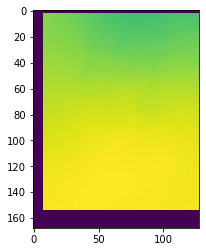

In [37]:
plt.imshow(cloud_met[2])

In [ ]:
plt.imshow(met_all[11])

In [6]:
keys = np.stack(list(data['cloud'].keys()))
keys = np.sort(keys)

In [7]:
keys[:24]

array(['2016010101', '2016010102', '2016010103', '2016010104',
       '2016010105', '2016010106', '2016010107', '2016010108',
       '2016010109', '2016010110', '2016010111', '2016010112',
       '2016010113', '2016010114', '2016010115', '2016010116',
       '2016010117', '2016010118', '2016010119', '2016010120',
       '2016010121', '2016010122', '2016010123', '2016010200'],
      dtype='<U10')

In [19]:
end = 2016010114

In [24]:
data_met = pd.read_pickle('data/data_train_met.pkl')
data_met = data_met['HGTs']
data_met_value = np.stack(list(data_met.values()))

In [25]:
met_list = np.stack(list(data_met.keys())).astype(int)
met_ind = np.where(met_list<end)[0][-1]
cloud_met = data_met_value[met_ind]

In [30]:
cloud_met.transpose(2,0,1).shape

(3, 168, 128)

In [28]:
met_list[met_ind]

2016010112

In [108]:
root_path = "/mnt/nasbi/no-backups/datasets/video_datasets/cloud_video/"

In [109]:
import glob
import cv2
import copy

In [110]:
test_list = glob.glob(root_path+'test/sat/*/*')
test_list = np.sort(test_list)

In [111]:
img16 = cv2.imread(root_path +'/train/sat/2016-01-02/2016-01-02-16-00.fv.png',0)[40:40+420, 130:130+340]
img17 = cv2.imread(root_path +'/train/sat/2017-01-02/2017-01-02-16-00.fv.png',0)[40:40+420, 130:130+340]
img18 = cv2.imread(root_path +'/test/sat/2018-01-02/2018-01-02-16-00.fv.png',0)[40:40+420, 130:130+340]

In [112]:
img16_new = copy.deepcopy(img16)/255
#img16_new[img16_new>0.5]=1
img17_new = copy.deepcopy(img17)/255
#img17_new[img17_new>0.5]=1
img18_new = copy.deepcopy(img18)/255
#img18_new[img18_new>0.5]=1

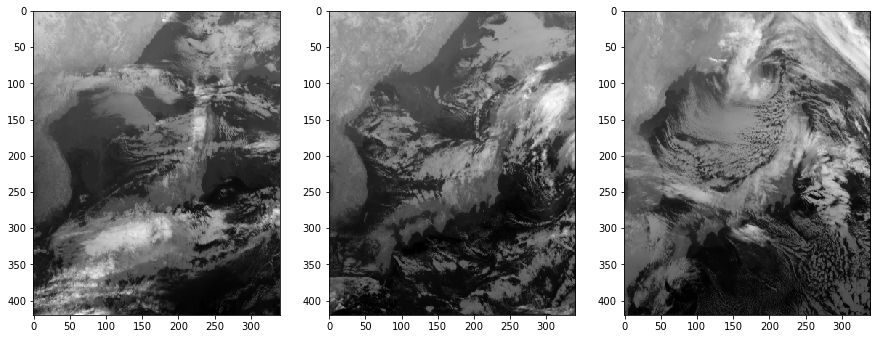

In [113]:
plt.figure(figsize=(15,15))

plt.subplot(1, 3, 1)
plt.imshow(img16_new,cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(img17_new,cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(img18_new,cmap='gray')
plt.show()

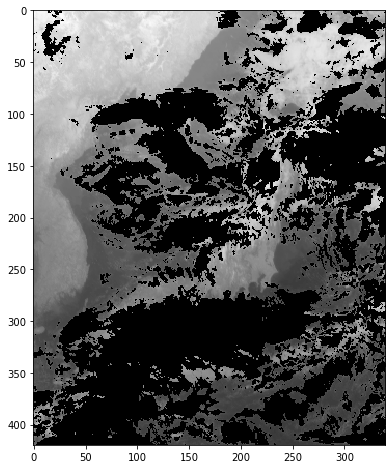

In [143]:
diff_16_17 = abs(img17_new-img16_new)
diff_16_17[diff_16_17>0.1] = 1
diff_16_17[diff_16_17<0.1] = 0
diff_16_17 = 1-diff_16_17

img_16_17 = (img17_new+img16_new)*diff_16_17/2
plt.figure(figsize=(8,8))
plt.imshow(img_16_17,cmap='gray')
plt.show()

In [148]:
diff_18 = abs(img_16_17-img18_new)
diff_18[diff_18>0.15] = 1
diff_18[diff_18<0.15] = 0
diff_18 = 1-diff_18

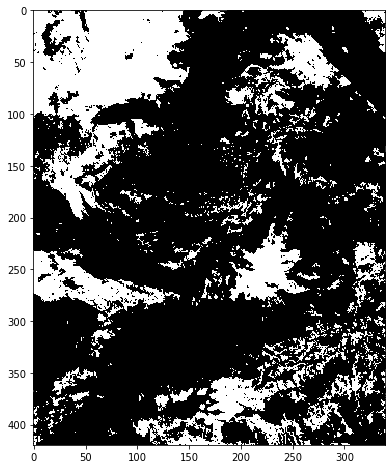

In [150]:
plt.figure(figsize=(8,8))
plt.imshow(diff_18,cmap='gray')
plt.show()

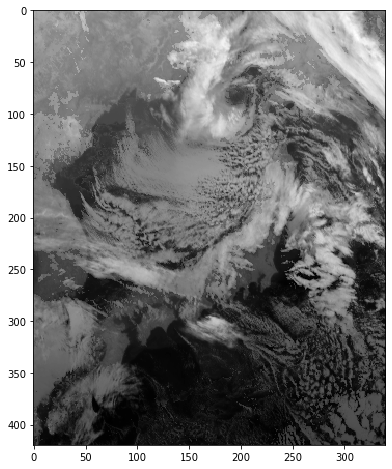

In [154]:
img18_fuse = img_16_17*diff_18+img18_new*(1-diff_18)
plt.figure(figsize=(8,8))
plt.imshow(img18_fuse,cmap='gray')
plt.show()

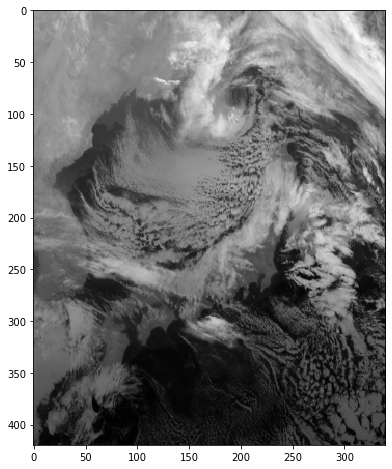

In [156]:
plt.figure(figsize=(8,8))
plt.imshow(img18_new,cmap='gray')
plt.show()